# Practico 5 (parte 5)

## Entrenar word embeddings

## Importación de módulos y librerías

In [5]:
# Inclusion de librerias y módulos
import os
import logging
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Algunas utilidades
from utiles import bcolors

# Importamos wrod2vec de la lib gensim
from gensim.models import Word2Vec

# Importamos PCA de sklear
from sklearn.decomposition import PCA

# Importamos logger para tener informacion de estado
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

plt.style.use('seaborn')
np.random.seed(42)
Nsamples = 200

In [49]:
positives = ['great', 'excellent', 'nice', 'awesome', 'amazing', 'fantastic', 'wonderful', 'perfect', 'nailed', 'brilliant', 'lovely', 'superb', 'beautiful','yupppppp']
emojis = [':grinning_face_with_smiling_eyes:', ':smiling_face_with_smiling_eyes:', ':face_with_tears_of_joy:', ':grinning_face:', ':smiling_face_with_sunglasses:',':smiling_face_with_open_mouth_&_smiling_eyes:']

2020-10-07 21:00:39,304 : INFO : loading Word2Vec object from ./20201007-003111_model_100-5-100-0.bin
2020-10-07 21:00:39,343 : INFO : loading wv recursively from ./20201007-003111_model_100-5-100-0.bin.wv.* with mmap=None
2020-10-07 21:00:39,359 : INFO : setting ignored attribute vectors_norm to None
2020-10-07 21:00:39,370 : INFO : loading vocabulary recursively from ./20201007-003111_model_100-5-100-0.bin.vocabulary.* with mmap=None
2020-10-07 21:00:39,373 : INFO : loading trainables recursively from ./20201007-003111_model_100-5-100-0.bin.trainables.* with mmap=None
2020-10-07 21:00:39,380 : INFO : setting ignored attribute cum_table to None
2020-10-07 21:00:39,387 : INFO : loaded ./20201007-003111_model_100-5-100-0.bin
<ipython-input-51-8b251c89b6b4>:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]
<ipython-input-51-8b251c89b6b4>:12: DeprecationWarning: Call to deprecated `__g

20201007-003111_model_100-5-100-0.bin - Tamaño del vocabulario 2591
Primeras 50 compoentes del vocabulario
['<url>', 'hey', '!', 'welcome', 'yup', '', 'looking', 'problem', "'ve", 'reviewed', 'finding', 'domain', 'square', 'root', 'function', 'let', "'s", 'work', 'together', 'find', 'exactly', "'re", 'stuck', 'tried', '?', 'simplifying', 'wrong', 'okay', 'actually', 'need', 'simplify', 'however', 'would', "n't", 'please', 'show', 'check', 'appreciate', 'seem', 'discuss', 'move', 'tell', 'mean', 'word', '"', 'meant', 'learned', 'far', 'x', 'good']
Ultimas 50 compoentes del vocabulario
['opens', 'neutrons', 'varma', 'pages', 'x/2', '):', 'electron', 'h+', 'ff', 'collinear', 'eliza', 'terminal', 'amber', 'bonds', 'ticket', 'tickets', 'bonding', 'delta', 'natalie', 'joe', 'breanna', 'f(1', 'molecule', 'pizza', 'matrices', 'oscar', 'wavelength', 'valence', 'slices', 'mackenzie', 'definite', 'yeap', 'index', 'riley', 'dipole', 'shinde', 'candaza', 'alonzo', 'okaye', 'dora', 'vavilakolanu', '

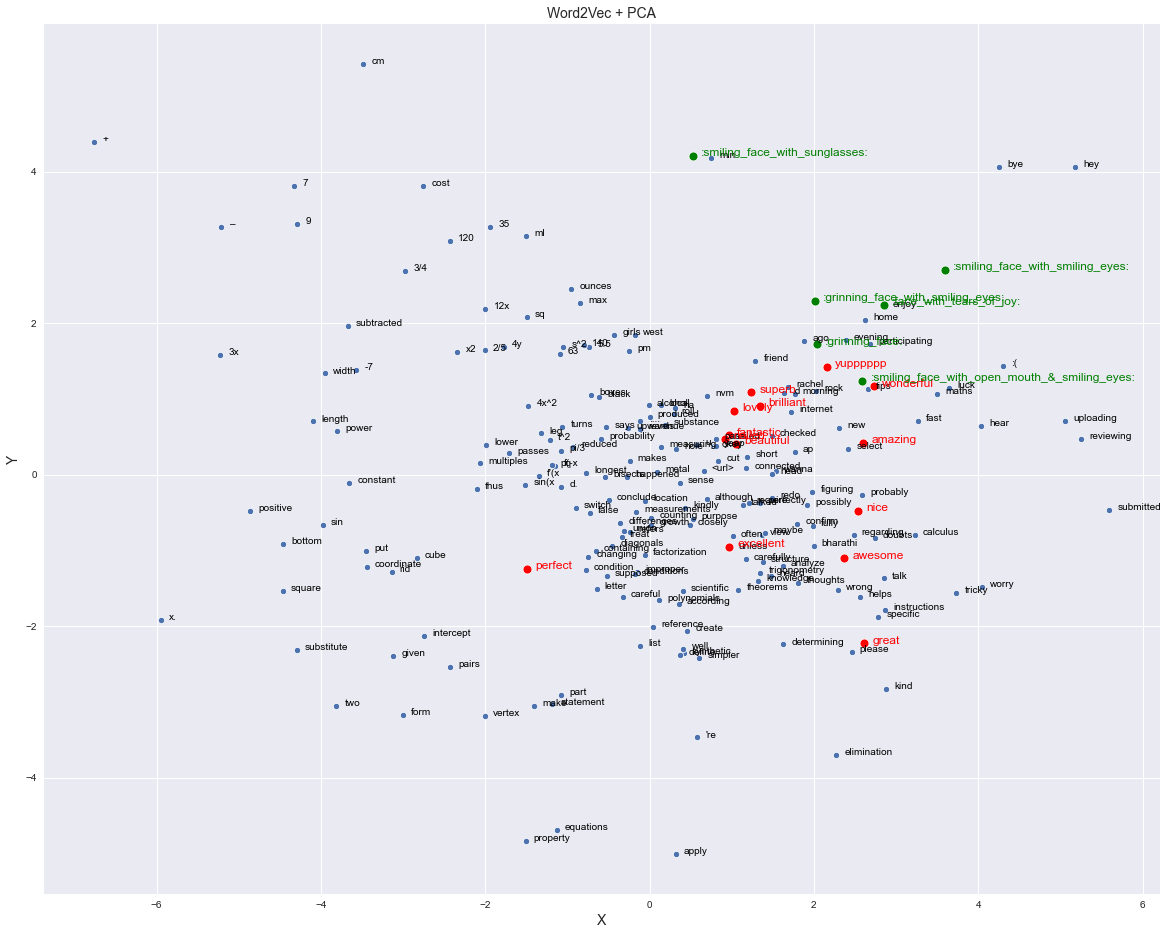

In [51]:
model = Word2Vec.load(os.path.join('.', '20201007-003111_model_100-5-100-0.bin'))

print(f'{bcolors.HEADER}20201007-003111_model_100-5-100-0.bin - Tamaño del vocabulario {len(list(model.wv.vocab))}{bcolors.ENDC}')
print(f'{bcolors.OKGREEN}Primeras 50 compoentes del vocabulario{bcolors.ENDC}')
print(f'{bcolors.OKBLUE}{list(model.wv.vocab.keys())[0:50]}{bcolors.ENDC}')
print(f'{bcolors.OKGREEN}Ultimas 50 compoentes del vocabulario{bcolors.ENDC}')
print(f'{bcolors.OKBLUE}{list(model.wv.vocab.keys())[-50:]}{bcolors.ENDC}')
print(f'{bcolors.FAIL}#######################################{bcolors.ENDC}')


X = model[model.wv.vocab]
Xp = model[positives]
Xe = model[emojis]

pca = PCA(n_components=2)
result = pca.fit_transform(X)
resultp = pca.transform(Xp)
resulte = pca.transform(Xe)

# create a scatter plot of the projection
index = np.random.choice(range(0, result.shape[0]), Nsamples, replace=False)

plt.figure(figsize=(20,16))
p1 = sns.scatterplot(x=result[index, 0], y=result[index, 1], s=40)
p2 = sns.scatterplot(x=resultp[:, 0], y=resultp[:, 1], s=80, color='red')
p3 = sns.scatterplot(x=resulte[:, 0], y=resulte[:, 1], s=80, color='green')

words = np.array(list(model.wv.vocab))[index]
result = result[index,:]
for i,word in enumerate(words):
    p1.text(result[i,0]+0.1, result[i,1], word,horizontalalignment='left', size='medium', color='black')#, weight='semibold')

for i,word in enumerate(positives):
    p2.text(resultp[i,0]+0.1, resultp[i,1], word,horizontalalignment='left', size='large', color='red')#, weight='semibold')
    
for i,word in enumerate(emojis):
    p2.text(resulte[i,0]+0.1, resulte[i,1], word,horizontalalignment='left', size='large', color='green')#, weight='semibold')

plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.title('Word2Vec + PCA', fontsize=14)
sns.despine()

In [4]:
Xp

array([[ 0.3153418 , -0.24009763,  1.617586  , ...,  0.5254837 ,
        -3.00786   , -0.74203676],
       [ 0.12747183, -1.4028147 ,  1.2670008 , ...,  0.56870174,
        -2.557137  , -1.3022215 ],
       [-1.708665  , -2.375702  ,  0.9165763 , ...,  0.4738699 ,
        -2.9127302 , -0.3863237 ],
       ...,
       [-0.4205041 , -0.36955246,  0.50669616, ...,  0.3816889 ,
        -0.8743778 , -0.34669158],
       [-0.14139968,  0.01169964,  0.17312512, ...,  0.05834861,
        -0.11202366, -0.12031562],
       [-1.5184206 , -1.3343567 ,  0.87388194, ...,  0.41523802,
         0.7566841 ,  0.05393678]], dtype=float32)

In [33]:
df = pd.read_csv('../dataset/yup_messages_preprocessed_curated.csv')

In [35]:
for i in range(100):
    print(df.text[i])

['<url>']
['hey', 'robert', '!', 'welcome', 'yup', '']
['looking', 'problem']
['', "'ve", 'reviewed', 'problem', 'finding', 'domain', 'square', 'root', 'function', 'let', "'s", 'work', 'together', 'find', 'exactly', "'re", 'stuck', '']
['tried', 'work', '?']
["'ve", 'tried', 'simplifying', 'wrong']
["'ve", 'tried', 'simplifying', 'wrong']
['okay', 'actually', 'need', 'find', 'domain', 'square', 'root', 'function', 'need', 'simplify', 'however', 'simplify', 'would', "n't", 'wrong']
['please', 'show', 'check', '?']
['2x√-x+7']
['2x√-x+7']
['okay', 'appreciate', 'work', "n't", 'seem', 'relevant', 'work', 'let', "'s", 'discuss', 'problem', 'together']
['move', 'tell', 'mean', 'word', '"', 'domain', '"', '?']
['meant', 'learned', 'domain', 'far', '?']
['x']
['x']
["'s", 'good', '!', 'x', 'values', 'defined', 'said', 'domain', 'function']
['let', 'explain', 'main', 'concept', 'use', 'find', 'domain', 'square', 'root', 'function']
['since', 'expression', 'written', 'inside', 'square', 'root',